In [22]:
import pandas as pd
from catboost import CatBoostRegressor,Pool
import numpy as np
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier
from statsmodels.tsa.deterministic import Fourier
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV, cross_validate, GridSearchCV, RepeatedKFold, cross_val_score, KFold
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import optuna
from optuna.samplers import TPESampler
import math
from catboost.utils import eval_metric
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
def scaler(df,features):
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df
target = 'price'

In [23]:
def plot_feature_importance(importance,names):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    p = fi_df.copy()
    fi_df = fi_df.head(60)
    #Define the size of the bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    ex = pd.DataFrame({'name':fi_df['feature_names'],'coeff':fi_df['feature_importance']})
   # ex.to_excel('explanation_reg.xlsx')
    return p

In [24]:
train = pd.read_csv('HW_train_main_data.csv')
q_1 = np.quantile(train[target],0.99)
q_2 = np.quantile(train[target],0.01)


train = train[train[target]<q_1]
train = train[train[target]>q_2]


train_add = pd.read_csv('HW_train_additional_data.csv')
train = train.sort_values(by=['timestamp'])
test = pd.read_csv('HW_test_main_data.csv').sort_values(by=['timestamp'])
test_add = pd.read_csv('HW_test_additional_data.csv')
train['type'] = 'train'
test['type'] = 'test'
data = pd.concat([train,test])
data_add = pd.concat([train_add,test_add]) 
data = data.merge(data_add,'left',on=['id'])
#data_add['population_cat'] = pd.qcut(data_add['population'],5,range(5))

In [25]:
data['first_floor'] =  0 
data.loc[data['floor'] ==1,'first_floor'] = 1

In [26]:
data['floor'].median()

6.0

In [27]:
data['llife'] = np.log(data['life_sq']+0.1)
data['full_sq'] = np.log(data['full_sq'] +0.0001)

In [28]:
fl = data[data['num_room']>=0]['full_sq'].fillna(np.median(data['full_sq']))
mf = data[data['num_room']>=0]['num_room']
X_train, X_test, y_train, y_test = train_test_split(fl.to_numpy(), mf.to_numpy(), test_size=0.3, random_state=42)

max_floor_pred= DecisionTreeRegressor()
max_floor_pred.fit(X_train[:, None],y_train)
pred = max_floor_pred.predict(X_test[:, None])
print (r2_score(y_test,pred))
data_ = data.copy()
data_['life_sq'] = data['life_sq'].fillna(0)
fsqnr = np.array(data[['full_sq','num_room']])
nr = [int(np.round(max_floor_pred.predict(np.array([el[0]]).reshape(1, -1)))) if math.isnan(el[1]) else el[1] for el in fsqnr]
data['num_room'] = nr

0.5990447502352874


In [29]:
fl = [5 if math.isnan(fl) else fl for fl in data['floor']]

/tmp/ipykernel_21561/4028188233.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fl, bins=50, kde=False,ax= axarray[0])
/tmp/ipykernel_21561/4028188233.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(data['floor']+0.1), bins=50, kde=False,ax= axarray[1])


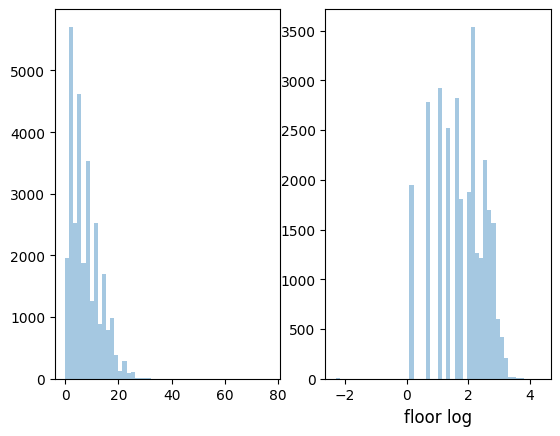

In [30]:
f,axarray = plt.subplots(1,2)
data['floor'] = fl
sns.distplot(fl, bins=50, kde=False,ax= axarray[0])
plt.xlabel('floor', fontsize=12)
sns.distplot(np.log(data['floor']+0.1), bins=50, kde=False,ax= axarray[1])

plt.xlabel('floor log', fontsize=12)
data['floor'] = np.log(data['floor']+0.1)

In [31]:

fl = data[data['max_floor']>=0]['floor'].to_numpy()
mf = data[data['max_floor']>=0]['max_floor'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(fl, mf, test_size=0.3, random_state=42)

max_floor_pred= DecisionTreeRegressor()
max_floor_pred.fit(X_train[:, None],y_train)
pred = max_floor_pred.predict(X_test[:, None])
print (r2_score(y_test,pred))
data_ = data.copy()
data_['floor'] = data['floor']
fsqnr = np.array(data_[['floor','max_floor']])
max_floor = [int(np.round(max_floor_pred.predict(np.array([el[0]]).reshape(1, -1)))) if math.isnan(el[1]) else el[1] for el in fsqnr]
data['max_floor'] = max_floor

0.2218539070549136


In [32]:
nr = data[(data.num_room>=0) & (data.life_sq>=0)]['num_room'].to_numpy()
ls = data[(data.num_room>=0) & (data.life_sq>=0)]['life_sq'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(nr, ls, test_size=0.3, random_state=42)

life_sq_pred= DecisionTreeRegressor()
life_sq_pred.fit(X_train[:, None],y_train)
pred = life_sq_pred.predict(X_test[:, None])
print (r2_score(y_test,pred))
data_['num_room'] = data['num_room'].fillna(0)
nrls = np.array(data_[['num_room','life_sq']])
lsq = [int(np.round(life_sq_pred.predict(np.array(   [el[0]]   ).reshape(1, -1)))) if math.isnan(el[1]) else el[1] for el in nrls]
data['life_sq'] = lsq

0.39079026603082867


In [33]:
data['year'] = pd.to_datetime(data['timestamp']).dt.year

In [34]:
stats = data[['year',target]].groupby(by=['year']).mean()[[target]].rename(columns={target:target+'_stats'})
data = data.merge(stats,'left',on=['year'])
stats

stats = data[['year',target]].groupby(by=['year']).std()[[target]].rename(columns={target:target+'_stats_std'})
data = data.merge(stats,'left',on=['year'])
stats

price_stats_std
year                 
2011     3.446762e+06
2012     3.559779e+06
2013     3.515691e+06
2014     3.754518e+06
2015     3.937319e+06

In [35]:
psm = data[target]/(data['full_sq']+1).astype(float)
psm = psm / np.max(psm)
data['psm'] = psm

In [36]:
stats = data[['sub_area','psm']].groupby(by=['sub_area']).mean()[['psm']].rename(columns={'psm':'psm_stats'}).reset_index()
data = data.drop(['psm'],axis=1)
data = data.merge(stats,'left',on=['sub_area'])

In [37]:
a = data[data['type']=='train']
len(data[~data['build_year'].isna()])

16292

In [38]:
len(data_add.columns[1:])

18

In [39]:
tpt = data[data_add.columns[1:]]
#for i in data_add.columns[1:]:
  #  if i !='population':
  #      data = data.loc[:,data.columns!=i]
tpt = tpt.select_dtypes(include=['number'])
from sklearn.decomposition import PCA
imputer = KNNImputer(n_neighbors=10)
tpt= imputer.fit_transform(tpt)
tpt = pd.DataFrame(tpt,columns=data_add.columns[1:])
tpt = np.log(tpt)

tf = tpt


#print (tf.head())
tf = tf.select_dtypes(include=['number']).dropna(axis=1, how='any')
tf[np.isinf(tf)] = 0
#print(np.isnan(tf).sum())
#print(np.isinf(tf).sum())
pca = PCA(n_components=9)
pca.fit(tf)
reduced_data = pca.transform(tf)
tpt_reduced_data = pd.DataFrame(reduced_data,columns=['tpt_pca1','tpt_pca2','tpt_pca3','tpt_pca4','tpt_pca5',
                                                      'tpt_pca6','tpt_pca7','tpt_pca8','tpt_pca9'])
#print (np.isnan(tpt_reduced_data).sum())
#tmp = pd.concat([tpt_reduced_data,prices],axis=1)
#print (tmp.corr())

/home/seb/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


/home/seb/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


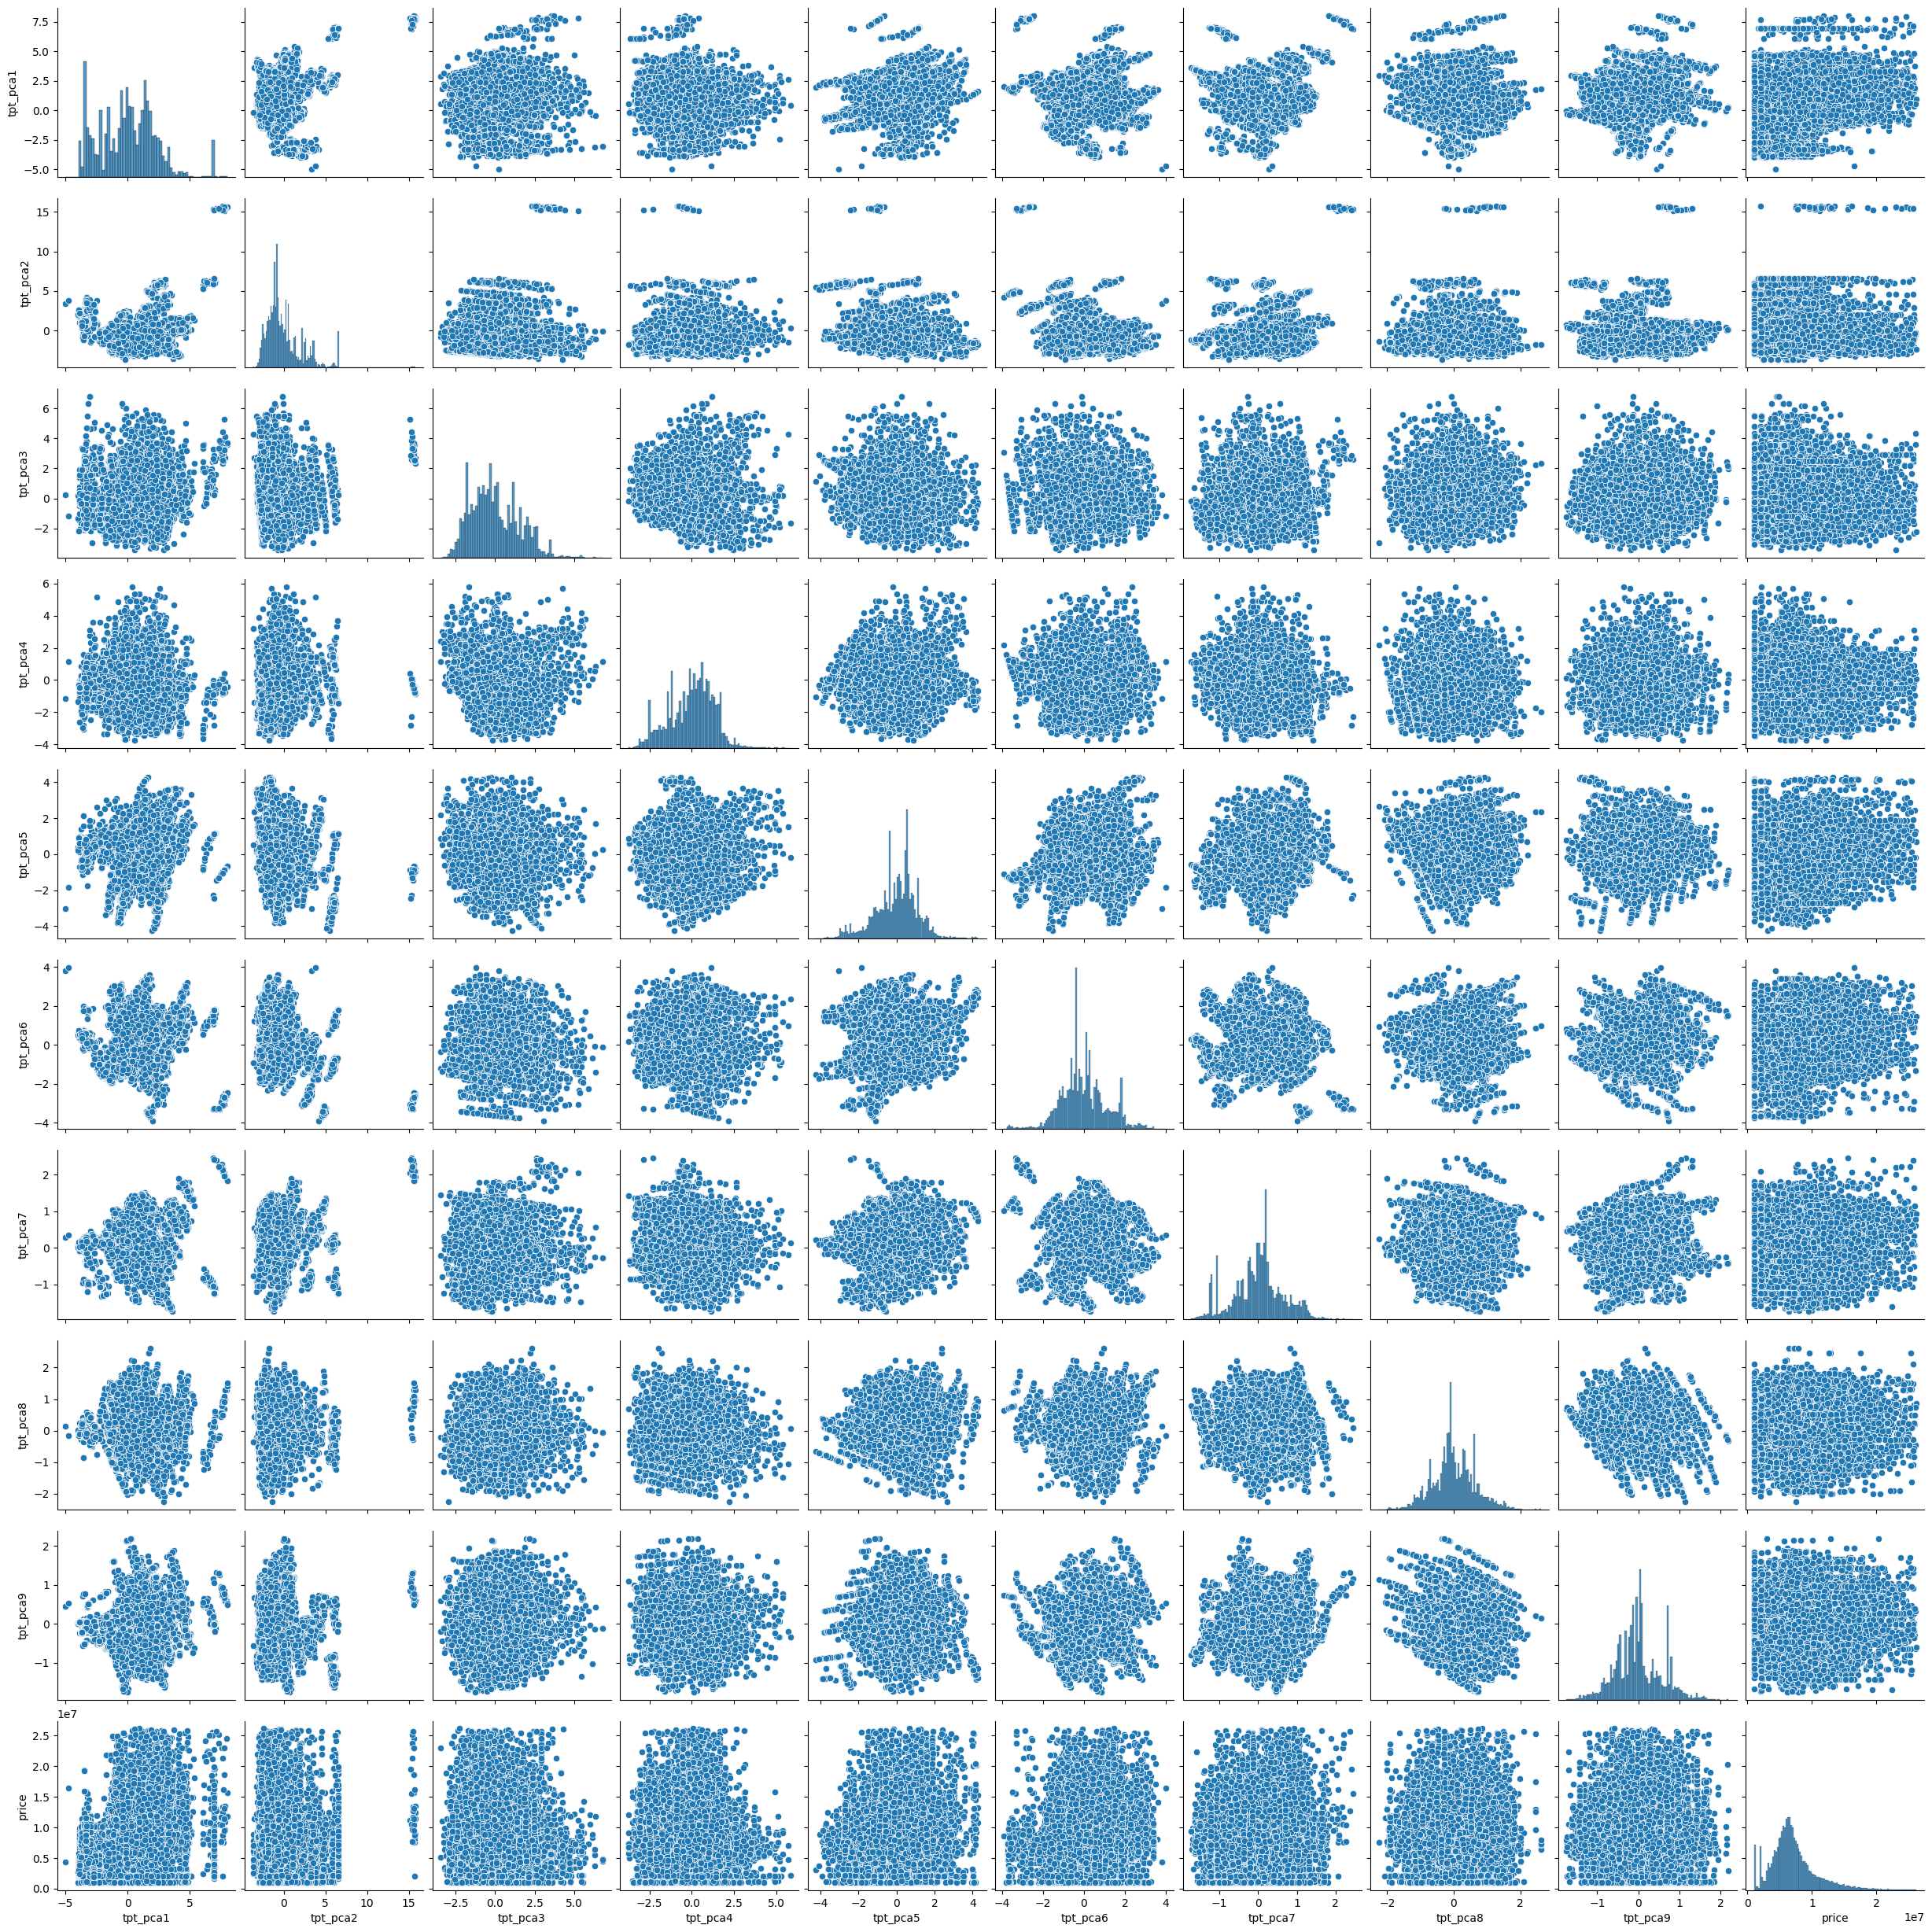

In [40]:
sns.pairplot(pd.concat([tpt_reduced_data,data[target]],axis=1),size = 2.5)
plt.show()

In [41]:
data = pd.concat([data,tpt_reduced_data],axis=1)

In [42]:
tpt = data[[ 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq', 'apartment condition',
       'sub_area']]
imputer = KNNImputer(n_neighbors=5)
tpt= imputer.fit_transform(tpt)
tpt = pd.DataFrame(tpt,columns=[ 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq', 'apartment condition',
       'sub_area'])
tpt = tpt.select_dtypes(include=['number'])
tpt = np.log(tpt)
from sklearn.decomposition import PCA
tf = tpt
#print (tf.head())
tf = tf.select_dtypes(include=['number']).dropna(axis=1, how='any')
tf[np.isinf(tf)] = 0
#print(np.isnan(tf).sum())
#print(np.isinf(tf).sum())
pca = PCA(n_components=2)
pca.fit(tf)
reduced_data = pca.transform(tf)
tpt_reduced_data = pd.DataFrame(reduced_data,columns=['s_pca1','s_pca2'])

/home/seb/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/seb/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


/home/seb/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


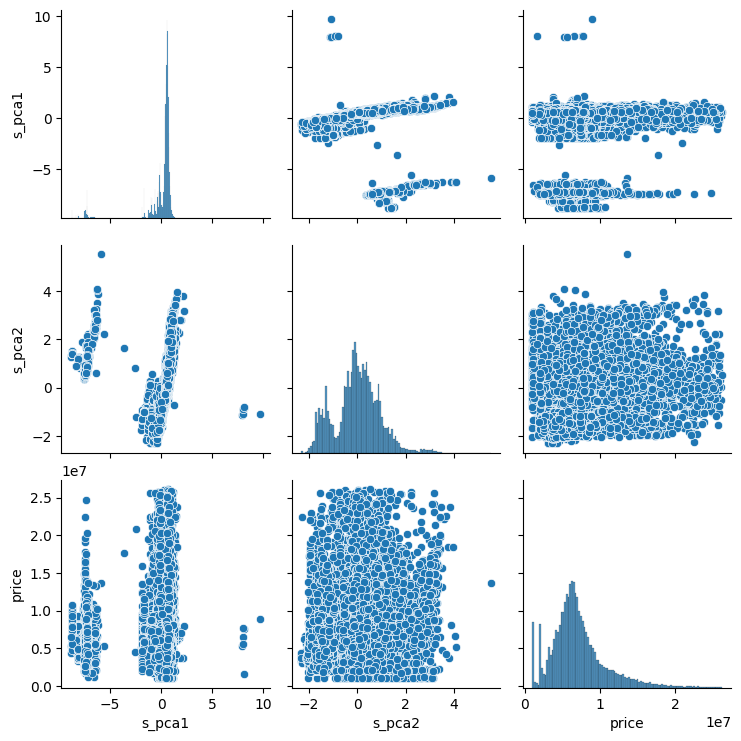

In [43]:
sns.pairplot(pd.concat([tpt_reduced_data,data[target]],axis=1),size = 2.5)
plt.show()

In [44]:
data = pd.concat([data,tpt_reduced_data],axis=1)

<Axes: >

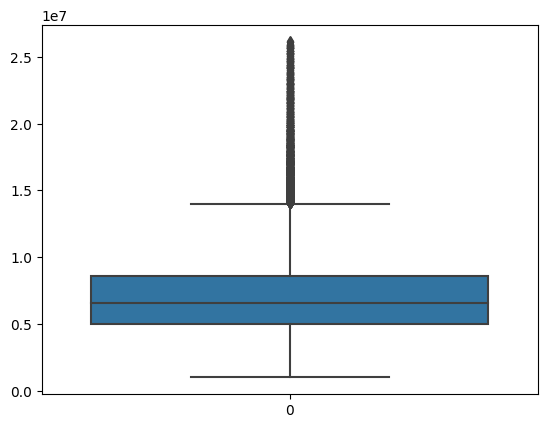

In [45]:
import seaborn as sns
sns.boxplot(data['price'])

In [46]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

data['build_year'] = data['build_year'].map(lambda x: np.nan if x > 2017 else x)
data['build_year'] = data['build_year'].map(lambda x: np.nan if x < 1900 else x)
data['build_cat'] = 0
data.loc[data['build_year']<=1930,'build_cat'] = 1
data.loc[(data['build_year']>1930)&(data['build_year']<=1960),'build_cat'] = 2
data.loc[(data['build_year']>1960)&(data['build_year']<=1998),'build_cat'] = 3
data.loc[(data['build_year']>1960)&(data['build_year']<=1998),'build_cat'] = 4
data.loc[(data['build_year']>1960)&(data['build_year']<=1990),'build_cat'] = 5
data.loc[(data['build_year']>1990)&(data['build_year']<=2000),'build_cat'] = 6
data.loc[(data['build_year']>2000)&(data['build_year']<=2008),'build_cat'] = 7
data.loc[(data['build_year']>2000)&(data['build_year']<2008),'build_cat'] = 8
data.loc[(data['build_year']==2008),'build_cat'] = 9
data.loc[(data['build_year']>2008),'build_cat'] = 10

In [47]:
data.loc[(data['build_year'].isna()),'build_cat'] = -1

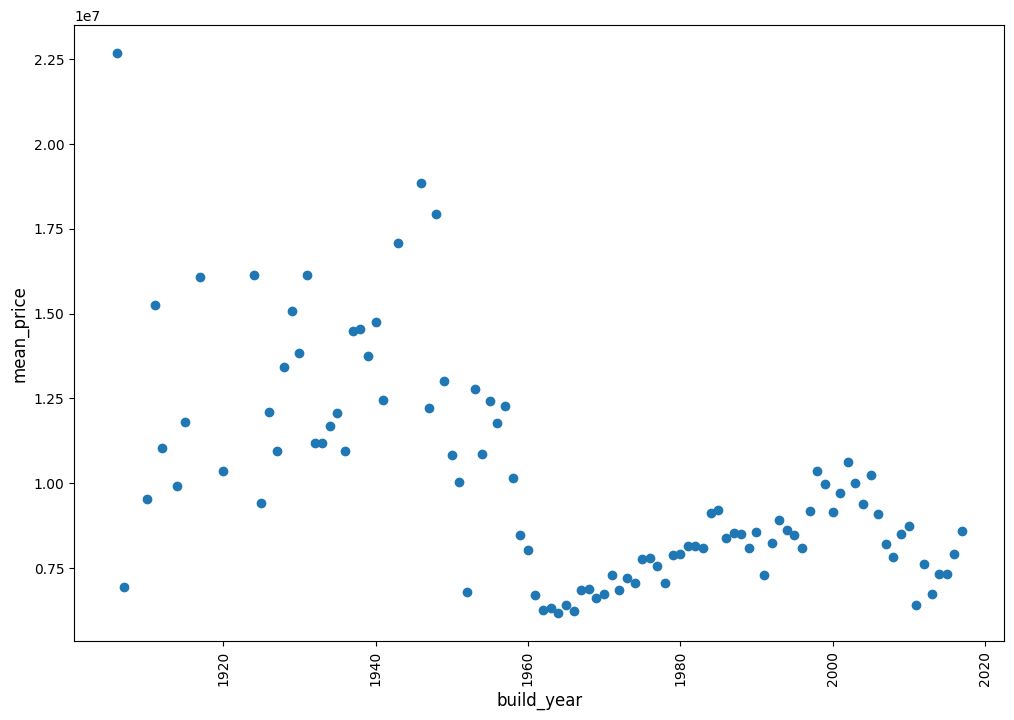

In [48]:
aggr_1 = data.sort_values(['build_year']).groupby(['build_year']).price.mean().reset_index()
plt.figure(figsize=(12,8))
plt.scatter(x='build_year', y='price', data=aggr_1)
plt.ylabel('mean_price', fontsize=12)
plt.xlabel('build_year', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [49]:
answers_tt = data.copy()
answers_tt['period_flag'] = 9

answers_tt.loc[answers_tt['timestamp'] < pd.to_datetime('2012-03-01'), 'period_flag'] = 1
answers_tt.loc[(answers_tt['timestamp']>=pd.to_datetime('2012-03-01')) &
               (answers_tt['timestamp'] <pd.to_datetime('2012-10-01')), 'period_flag'] = 2
answers_tt.loc[(answers_tt['timestamp']>=pd.to_datetime('2012-10-01')) &
               (answers_tt['timestamp'] <pd.to_datetime('2013-03-01')), 'period_flag'] = 3
answers_tt.loc[(answers_tt['timestamp']>=pd.to_datetime('2013-03-01')) &
               (answers_tt['timestamp'] <pd.to_datetime('2013-07-01')), 'period_flag'] = 4 
answers_tt.loc[(answers_tt['timestamp']>=pd.to_datetime('2013-07-01')) &
               (answers_tt['timestamp'] <pd.to_datetime('2014-01-01')), 'period_flag'] = 5 
answers_tt.loc[(answers_tt['timestamp']>=pd.to_datetime('2014-01-01')) &
               (answers_tt['timestamp'] <pd.to_datetime('2014-04-01')), 'period_flag'] = 6 
answers_tt.loc[(answers_tt['timestamp']>=pd.to_datetime('2014-04-01')) &
               (answers_tt['timestamp'] <pd.to_datetime('2014-08-01')), 'period_flag'] = 7 
answers_tt.loc[(answers_tt['timestamp']>=pd.to_datetime('2014-08-01')) &
               (answers_tt['timestamp'] <pd.to_datetime('2015-02-01')), 'period_flag'] = 8 
data = answers_tt.copy()

In [50]:
np.max(data['floor'])

4.345103280569283

In [51]:
info = ['id', 'timestamp','type']
data['timestamp_int'] = data['timestamp'].astype(int)
features = [x for x in data.columns if x !='target' and x not in info]
cat_features = ['first_floor','period_flag','build_cat','max_floor','apartment condition',
                'build_year','num_room','material','cat_big_1','cat_big_2','population_cat','cat_building','sub_area',
                'period_flag']

data['Week_Number'] = data['timestamp'].dt.isocalendar().week
imputer = KNNImputer(n_neighbors=11)
data[features] = imputer.fit_transform(data[features])


In [52]:
data['age'] = data["build_year"] - data['year']
data['lful'] = np.log(train['full_sq']+0.0001)
data['cat_big_1'] = pd.qcut(data['full_sq'],4,labels = list(range(4))).astype(int)
data['cat_big_2'] = pd.qcut(data['kitch_sq'],4,labels = list(range(4))).astype(int)
data['population_cat'] = pd.qcut(data['population'],4,labels = list(range(4))).astype(int)
data['year']  = pd.to_datetime(data['timestamp']).dt.year
data['month']  = pd.to_datetime(data['timestamp']).dt.month
data['full_sq_na_num_room'] = data['full_sq']/(data['num_room'])
data['full_sq_na_life'] = data['full_sq']/(data['life_sq'])
data['rate_floor_1'] = data['floor']/(data['max_floor']+1)
data['num_room'] = data['num_room'].astype('int')
data['floor'] = data['floor'].astype('int')
data['max_floor'] = data['max_floor'].astype('int')
data['full_sq_1']=data['full_sq']/np.max(data['full_sq'])
data['full_sq_2']=data['full_sq']/data['kitch_sq']


data['full_sq_na_num_room'] = data['full_sq']/(data['num_room'])
data['rate_floor_1'] = data['floor']/(data['max_floor']+1)

data['life_sq_1']=data['full_sq']/np.max(data['life_sq'])
exclude = ['cat_floor','mosque','cat_green','month']

features = [x for x in data.columns if x != target and x not in info and x not in exclude]
cat_features = [x for x in cat_features if x in features]
for i in cat_features:
    data[i] = data[i].fillna(-1).astype(int)


In [53]:
from tqdm.auto import tqdm
def cv(train,features,cat_features,params):
    cv = KFold(3,shuffle=True,random_state = 13)
    rmse = []
    mape_ = []
    r2 = []
    for cv_ in tqdm(cv.split(train),total=3):

        X_train, X_test = train[train.index.isin(cv_[0])],train[train.index.isin(cv_[1])]



        train_pool = Pool(X_train[features],label=X_train[target],cat_features=cat_features)
        model = CatBoostRegressor(**params)
        model.fit(train_pool)


        y_pred = model.predict(X_test[features])
        
        
       # X_test[target] = np.exp(X_test[target])
       # y_pred = np.exp(y_pred)
        print(np.sqrt(mse(y_pred,X_test[target])))
        print(mape(y_pred,X_test[target]))
        print(r2_score(y_pred,X_test[target]))

        rmse.append(np.sqrt(mse(y_pred,X_test[target])))
        mape_.append(mape(y_pred,X_test[target]))
        r2.append(r2_score(X_test[target],y_pred))
    return np.mean(r2),np.mean(mape_),np.mean(rmse)

In [54]:

params = {'combinations_ctr': 'Borders',
'simple_ctr': 'Borders','random_seed':875,'verbose':500,'num_trees':1000,'task_type':'CPU','learning_rate':1e-1}

In [56]:
features = list(set(features))
cat_features = list(set(cat_features))

In [58]:

from sklearn.ensemble import VotingRegressor
train  = data[data['type']=='train'].reset_index(drop=True)
test  = data[data['type']=='test'].reset_index(drop=True)
cat_features = list(set(cat_features)) 
cv(train,features,cat_features,params)

  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 3534610.4602993	total: 53.1ms	remaining: 53.1s
500:	learn: 1793769.3947643	total: 1.86s	remaining: 1.85s
999:	learn: 1552706.3874762	total: 3.75s	remaining: 0us
2235960.9814659692
0.17789218580995544
0.44238376958952896
0:	learn: 3538424.8747653	total: 4.78ms	remaining: 4.77s
500:	learn: 1814226.6072318	total: 1.86s	remaining: 1.85s
999:	learn: 1568937.8751718	total: 3.76s	remaining: 0us
2206801.4116279646
0.17273420392384922
0.48453306006034347
0:	learn: 3532708.3188621	total: 4.59ms	remaining: 4.59s
500:	learn: 1842511.2832568	total: 1.82s	remaining: 1.81s
999:	learn: 1603043.5745577	total: 3.72s	remaining: 0us
2166556.8910719957
0.1767077496256117
0.4789631049871531


(0.6485593792072232, 0.1757780464531388, 2203106.42805531)

In [59]:

from sklearn.ensemble import VotingRegressor

train  = data[data['type']=='train'].reset_index(drop=True)
#q_1  = np.quantile(train[target],0.01)
#train = train[train[target]>q_1]
test  = data[data['type']=='test'].reset_index(drop=True)

model = CatBoostRegressor(**params)
train_pool = Pool(train[features],train[target],cat_features=cat_features)
model.fit(train_pool)
test_pool = Pool(test[features],test[target],cat_features=cat_features)
test['predicted_price'] = model.predict(test_pool)
test.sort_values(by=['id'])[['id','predicted_price']].to_csv('prediction_f.csv',index=False)

0:	learn: 3535500.3395023	total: 8.05ms	remaining: 8.04s
500:	learn: 1896962.9957488	total: 2.32s	remaining: 2.31s
999:	learn: 1701545.3462381	total: 4.71s	remaining: 0us


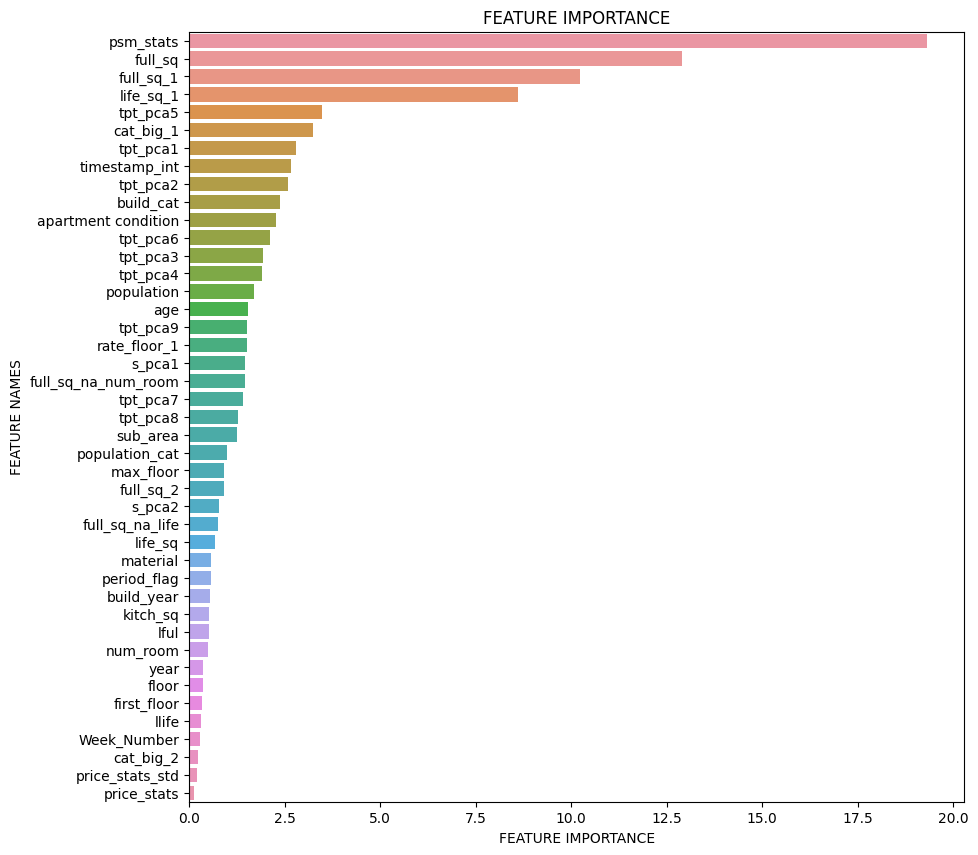

In [125]:
top_5 = plot_feature_importance(model.get_feature_importance(),features)